# **Feature Peaks PLS**

This notebook is for the analysis of the data that are produced from peaks_PLS.py. 

It is divided into:
1. **Data loading**
2. **Single Emotions peaks**
3. **Mean of emotions**
4. **Magnitude of emotions**

In [4]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from helpers_PLS import *

## **Emotions peaks**

Counting points function is used to count the number of peaks in each emotion.

In [ ]:
emotions = ['Happiness', 'Sad', 'Anxiety', 'Love', 'Fear', 'Regard']
list_movies = ['AfterTheRain', 'BetweenViewings', 'BigBuckBunny', 'Chatter', 'FirstBite', 'LessonLearned', 'Payload', 'Sintel', 'Spaceman', 'Superhero', 'TearsOfSteel', 'TheSecretNumber', 'ToClaireFromSonny', 'YouAgain']
thresholds = [1, 1.5, 2]

count_pts = counting_points(list_movies, thresholds, emotions)
print(count_pts)

Read the data on the peaks for the concatenated movie.

In [ ]:
# Read the data of the PLS calculated on the peaks of the emotions  for the concatenated movies
peaks_data = pd.read_csv('/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_emoPeaks/PLSpeaks_emotions_concat.csv')
peaks_data.dropna(inplace=True)
peaks_data = peaks_data[peaks_data['Region'] == 'ALL']
print(peaks_data.columns)

movies = peaks_data['Movie'].unique()                                   # list of the movies
emotions_control = peaks_data['Feature'].unique()                       # list of the emotions
emotions = [x for x in emotions_control if not x.startswith('Control')] # list of the emotions without the control ones
thresholds = peaks_data['threshold'].unique()                           # list of the thresholds
print(thresholds)

# Read the data for the PLS computed on all the movies concatenated
data_all = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_csv/PLS_bold_ALL_concatmovies.csv', index_col=0).reset_index().drop(columns=['Movie', 'LC'])
data_all['Region'] = 'ALL'
data_all['Type'] = 'bold'
data_all.reset_index(inplace=True, drop=False)
data_all.rename(columns={'index': 'bootstrap_round'}, inplace=True)
data_all.head(1)


In [ ]:
emotions = ['Happiness', 'Sad', 'Anxiety', 'Love', 'Fear', 'Regard']

lenght_movies = {}
concat_emo = pd.DataFrame()
last_movie = ''
for movie in list_movies:
    labels = pd.read_json(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/EmoData/Annot13_{movie}_stim.json')[['Columns']]
    data = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/EmoData/Annot13_{movie}_stim.tsv', sep = '\t', header = None)
    data.columns = labels['Columns']
    if last_movie != '':
        lenght_movies[movie] = len(data) + lenght_movies[last_movie]
    else:
        lenght_movies[movie] = len(data)
    concat_emo = pd.concat([concat_emo, data], axis = 0)
    concat_emo.reset_index(drop=True, inplace=True)
    last_movie = movie

palette = sns.color_palette("Set2", len(emotions))

# Determine the layout of the subplots
print(len(emotions))
n_rows = int(len(emotions) ** 0.5)
n_cols = int(len(emotions) / n_rows) + (len(emotions) % n_rows > 0)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(35, 16))  # Adjust figsize as needed
fig.suptitle('Emotions for the Concatenated Movies', fontsize=40, fontweight='bold')

for i, emotion in enumerate(emotions):
    # Determine the current subplot row and column
    row = i // n_cols
    col = i % n_cols

    if n_rows > 1:
        ax = axes[row, col]
    else:
        ax = axes[col]

    ax.plot(concat_emo[emotion], label=emotion, color=palette[i])
    ax.set_title(emotion, fontsize=25)
    ax.set_xlabel('Time', fontsize=25, labelpad=10)
    ax.set_ylabel('Intensity', fontsize=25)
    ax.axhline(y=1, color='grey', linestyle='-')
    ax.axhline(y=2, color='red', linestyle='-')
    ax.axhline(y=1.5, color='blue', linestyle='-')
    ax.legend(loc='upper right', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_ylim([-2, 4])

    # for movie in list_movies:
    #     ax.plot(lenght_movies[movie], -2, marker='o', color='red', markersize=10)
    #     ax.text(lenght_movies[movie], -4, movie, ha='center', fontsize=15, rotation=90)

#fig.delaxes(axes[1, 3])
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust this as needed for the title
plt.show()

In [ ]:
significant_peaks = peaks_data[peaks_data['P-value'] < 0.05]
significant_peaks = significant_peaks.groupby(['Region', 'bootstrap_round', 'Feature', 'threshold']).sum()['Covariance Explained'].reset_index()
significant_peaks['Control'] = significant_peaks['Feature'].apply(lambda x: 1 if x.split('_')[0] == 'Control' else 0)
significant_peaks['Feature'] = significant_peaks['Feature'].apply(lambda x: x.split('_')[-1])

In [ ]:
thresholds = [1, 1.5, 2]
print(emotions)

significant = retrieve_significant_data(peaks_data, data_all, count_pts, thresholds, emotions)
plot_peaks(significant, emotions, thresholds)

In [ ]:
increase_thr(significant, emotions)

## **Mean values**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def concat_emo(server = True):
    list_movies = ['AfterTheRain', 'BetweenViewings', 'BigBuckBunny', 'Chatter', 'FirstBite', 'LessonLearned', 'Payload', 'Sintel', 'Spaceman', 'Superhero', 'TearsOfSteel', 'TheSecretNumber', 'ToClaireFromSonny', 'YouAgain']
    data_concat = pd.DataFrame()
    for movie_name in list_movies:
        if server == True:
            PATH  = '/media/miplab-nas2/Data2/Movies_Emo/Flavia_E3/EmoData'
        else:
            PATH = '/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/EmoData'
        labels = pd.read_json(PATH + f'/Annot13_{movie_name}_stim.json')
        data = pd.read_csv(PATH + f'/Annot13_{movie_name}_stim.tsv', sep = '\t', header = None)
        data.columns = labels['Columns']
        data_concat = pd.concat([data_concat, data], axis=0)
    data_concat.reset_index(drop=True, inplace=True)
    print('The shape of the data_concat is: ', data_concat.shape)
    return data_concat

def count_emotions_above_threshold(data, threshold, emotions):
    """Counts the number of points above a given threshold for specified emotions."""
    return len(data[data[emotions].mean(axis=1) > threshold])

def plot_emotions(data, threshold, count_pts):
    """Plots emotions with annotations."""
    sns.set_palette(sns.color_palette("Set2", 8))
    # create two plots, one for positive and one for negative emotions
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    for i, emotions in enumerate(['positive', 'negative']):
        ax[i].plot(data[emotions], label=emotions, color=sns.color_palette()[i])
    
        for thr in threshold:
            ax[i].axhline(y=thr, color='grey', linestyle='-')
        ax[i].set_xlabel('Time')
        ax[i].set_ylabel('Emotions')
        ax[i].set_title(f'Emotions Over Time')
        ax[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        ax[i].annotate(f'n 1.0 = {count_pts[1][emotions]}', xy=(0.75, 0.95), xycoords='axes fraction', fontsize = 14)
        ax[i].annotate(f'n 1.5 = {count_pts[1.5][emotions]}', xy=(0.75, 0.90), xycoords='axes fraction', fontsize = 14)
        ax[i].annotate(f'n 1.7 = {count_pts[1.7][emotions]}', xy=(0.75, 0.85), xycoords='axes fraction', fontsize = 14)
    plt.show()

def counting_points(thresholds):
    """Counts the number of points above given thresholds for positive and negative emotions."""
    count_pts = {}
    positive_emotions = ['Love', 'Regard', 'WarmHeartedness', 'Pride', 'Satisfaction', 'Happiness']
    negative_emotions = ['Sad', 'Anxiety', 'Fear', 'Guilt', 'Disgust', 'Anger']

    data = concat_emo(server = False)
    data['positive'] = data[positive_emotions].mean(axis=1)
    data['negative'] = data[negative_emotions].mean(axis=1)

    for thr in thresholds:
        positive_count = count_emotions_above_threshold(data, thr, positive_emotions)
        negative_count = count_emotions_above_threshold(data, thr, negative_emotions)
        count_pts[thr] = {'positive': positive_count, 'negative': negative_count, 'All Movie': len(data)}

    return count_pts, data

# Example usage:
thresholds = [1, 1.5, 1.7]  # Example thresholds
count_pts, data = counting_points(thresholds)
plot_emotions(data, thresholds, count_pts)
count_pts

In [ ]:
peaks_data = pd.read_csv('/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_emoPeaks/PLSmean_concat.csv')
peaks_data.dropna(inplace=True)
peaks_data[(peaks_data['threshold'] != 1.0) & (peaks_data['threshold'] != 1.5)].threshold = 1.7

# get the data for positive emotions
thresholds = peaks_data[peaks_data['Emotion'] == 'positive'].threshold.unique()
thresholds

In [ ]:
# Read the data for the PLS computed on all the movies concatenated
data_all = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_csv/PLS_bold_ALL_concatmovies.csv', index_col=0).reset_index().drop(columns=['Movie', 'LC'])
data_all['Region'] = 'ALL'
data_all['Type'] = 'bold'
data_all['Emotion'] = 'All movie'
data_all.reset_index(inplace=True, drop=False)
data_all.rename(columns={'index': 'bootstrap_round'}, inplace=True)

In [ ]:
# round the threshold columns to 1 decimal
peaks_data['threshold'] = peaks_data['threshold'].apply(lambda x: round(x, 1))

In [ ]:
peaks_data.rename(columns={'Emotion': 'Feature'}, inplace=True)
data_all.rename(columns={'Emotion': 'Feature'}, inplace=True)

significant = retrieve_significant_data(peaks_data, data_all, count_pts, [1, 1.5, 1.7], ['positive', 'negative'])
significant.fillna(50, inplace=True)
plot_peaks(significant, ['positive', 'negative'], thresholds)

In [ ]:
increase_thr(significant, ['positive', 'negative'])

## Plot for the presentation of 16/11/2023

This is the official plot 

In [ ]:
# emotions = ['Happiness']
# thresholds = [1, 1.5, 2]
# for movie in ['Sintel', 'Superhero', 'TearsOfSteel', 'TheSecretNumber']:

#     # read the emotion data columns:        Movie Region bootstrap_round emotion Covariance Explained
#     peaks_data = all_peaks_data
#     significant = peaks_data[peaks_data['P-value'] < 0.05]
#     significant = significant.groupby(['Movie', 'Region', 'bootstrap_round', 'Emotion']).sum()['Covariance Explained'].reset_index()

#     # read control
#     significant_control = all_emo_control
#     significant_all_movie = data_all_movie[data_all_movie['P-value'] < 0.05]
#     significant_all_movie = significant_all_movie.groupby(['Movie', 'Region', 'bootstrap_round', 'Emotion']).sum()['Covariance Explained'].reset_index()

#     # merge the two dataframes
#     significant = pd.concat([significant, significant_control, significant_all_movie], axis = 0)
#     significant = significant[significant['Movie'] == movie]

#     # add a control column to the dataframe if emotion ends with control
#     significant['Control'] = significant['Emotion'].apply(lambda x: 1 if x.split('_')[-1] == 'control' else 0)

#     # add the number of points to the dataframe
#     for emotion in emotions:
#         significant.loc[significant['Emotion'] == emotion.split('_')[0], 'Number of points'] = count_pts[movie][thr][emotion]
#     significant.loc[significant['Emotion'] == 'All movie', 'Number of points'] = count_pts[movie][thr]['All movie']

#     # EMOTION PEAKS
#     labels = pd.read_json(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/EmoData/Annot13_{movie}_stim.json')[['Columns']]
#     data = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/EmoData/Annot13_{movie}_stim.tsv', sep = '\t', header = None)
#     data.columns = labels['Columns']
#     emotions = peaks_data.emotion.unique()

#     # PLOT
#     palette = sns.color_palette("Set2", 8)
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
#     box = ax1.get_position()
#     ax1.set_position([box.x0, box.y0, box.width * 1.25, box.height])
#     box = ax2.get_position()
#     ax2.set_position([box.x0 + 0.1, box.y0, box.width * 1, box.height])
#     ax1.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
#     ax2.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

#     palette_sns = {
#         'Anxiety': sns.color_palette("Set2", 8)[3],
#         'Anxiety_control': sns.color_palette("Set2", 8)[-1],
#         'Sad': sns.color_palette("Set2", 8)[2],
#         'Sad_control': sns.color_palette("Set2", 8)[-1],
#         'Happiness': sns.color_palette("Set2", 8)[1],
#         'Happiness_control': sns.color_palette("Set2", 8)[-1],
#         'Love': sns.color_palette("Set2", 8)[0],
#         'Love_control': sns.color_palette("Set2", 8)[-1],
#         'All movie': sns.color_palette("Set2", 8)[5],
#     }
#     # plot the boxplot
#     order_emotions = ['All Movie']
#     for emotion in ['Happiness']:
#         order_emotions.append(emotion)
#         order_emotions.append(emotion + '_control')

#     sns.boxplot(x = 'Emotion', y = 'Covariance Explained', order = order_emotions, data = significant, ax = ax1, palette = palette_sns)
#     list_n = []
#     for emo in order_emotions:
#         n = significant[significant['Emotion'] == emo.split('_')[0]]['Number of points'].unique()
#         if len(n) == 0:
#             n = 0
#         else:
#             n = n[0]
#         list_n.append(f'{emo}: {int(n)}')

#     ax1.set_xticklabels(list_n, rotation=45, ha='right')
#     # give colors to the x labels
#     for i, emotion in enumerate(list_n):
#         if emotion.split(':')[0] in emotions:
#             ax1.get_xticklabels()[i].set_color(palette[list(emotions).index(emotion.split(':')[0])])
#         else:
#             ax1.get_xticklabels()[i].set_color('black')
#     ax1.set_title(f'Emotion Peaks in {movie}')
#     ax1.set_xlabel('Regions')
#     ax1.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

#     list_emot = ['Happiness', 'All Movie']
#     for emotion in list_emot:
#         ax1.annotate(f'n = {int(n)}', xy=(list(list_emot).index(emotion), -0.25), xytext=(list(list_emot).index(emotion), 0.05), fontsize = 12)

#     # plot the lineplot
#     for i, emotion in enumerate(list_emot[0:-1]):
#         print(emotion)

#         n = significant[significant['Emotion'] == emotion]['Number of points'].unique()
#         if len(n) == 0:
#             n = 0
#         else:
#             n = n[0]
#         plt.plot(data[emotion], label = emotion + f': {n}', color = palette[list(emotions).index(emotion)])

#     ax2.set_title(f'Emotion Peaks in {movie}')
#     ax2.set_xlabel('Time')
#     ax2.set_ylabel('Emotions')
#     ax2.axhline(y=1, color='grey', linestyle='-')
#     ax2.legend()
    

#     plt.show()

# **Peaks from features extracted**

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from helpers_PLS import *

In [ ]:
# Read the data of the PLS calculated on the peaks of the emotions  for the concatenated movies
peaks_data = pd.read_csv('/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_emoPeaks/PLSpeaks_features_extracted_concat.csv')
data_all = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_csv/PLS_bold_ALL_concatmovies.csv', index_col=0).reset_index().drop(columns=['Movie', 'LC'])

peaks_data, data_all, features, thresholds = preprocess_peaks_concat(peaks_data, data_all)

In [ ]:
concatenated_features = extract_features_concat(cluster = False)

features = concatenated_features.columns
count_pts = count_features_above_threshold(concatenated_features, [1.5, 2, 2.5], features)
print(count_pts)

# plot the features
def plot_features(features, thresholds):
    num_features = features.shape[1]
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))  # Adjusted for 2x3 grid
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

    # Predefined colors
    colors = sns.color_palette("Set2", num_features)
    
    for i, feature in enumerate(features.columns):
        ax = axes[i]
        ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
        ax.set_title(f'Feature: {feature}', fontsize=20)
        ax.set_xlabel('Time', fontsize=15)
        ax.set_ylabel(feature, rotation=90, labelpad=20, fontsize=15)
        ax.plot(features[feature], color=colors[i])  # Use different color for each line
        ax.set_ylim([-2, 10])

        # Add the threshold lines
        for thr in thresholds:
            ax.axhline(y=thr, color='grey', linestyle='-', alpha=0.5)

        # add a text with the number of points above the threshold
        ax.annotate(f'n {1.5} = {count_pts[1.5][feature]}', xy=(0.75, 0.90), xycoords='axes fraction', fontsize = 15)
        ax.annotate(f'n {2} = {count_pts[2][feature]}', xy=(0.75, 0.85), xycoords='axes fraction', fontsize = 15)
        ax.annotate(f'n {2.5} = {count_pts[2.5][feature]}', xy=(0.75, 0.80), xycoords='axes fraction', fontsize = 15)

    plt.tight_layout()
    plt.show()

plot_features(concatenated_features, [1.5, 2, 2.5])

In [ ]:
thresholds = [1.5, 2, 2.5]

significant = retrieve_significant_data(peaks_data, data_all, count_pts, thresholds, features)
plot_peaks(significant, ['spectralflux', 'average_brightness', 'average_saturation', 'average_hue'], thresholds)

In [ ]:
features = ['spectralflux', 'average_brightness',
       'average_saturation', 'average_hue']
increase_thr(significant, features)

# **Peaks from concat movie points**

In [5]:
# Read the data of the PLS calculated on the peaks of the emotions  for the concatenated movies
peaks_data = pd.read_csv('/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_emoPeaks/PLSpeaks_emotions_concat_pts.csv')
data_all = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_csv/PLS_bold_ALL_concatmovies.csv', index_col=0).reset_index().drop(columns=['Movie', 'LC'])

peaks_data, data_all, features, thresholds = preprocess_peaks_concat(peaks_data, data_all)

In [14]:
peaks_data
significant_peaks = peaks_data[peaks_data['P-value'] < 0.05]
significant_peaks = significant_peaks.groupby(['Region', 'bootstrap_round', 'Feature', 'Number of points', 'threshold']).sum()['Covariance Explained'].reset_index()


,Region,bootstrap_round,Feature,Number of points,threshold,Covariance Explained
0,ALL,0,Anxiety,50,2.58,0.988707
1,ALL,0,Anxiety,100,2.39,0.743096
2,ALL,0,Anxiety,150,2.18,0.467970
3,ALL,0,Control_0_Anxiety,50,2.58,1.454006
4,ALL,0,Control_0_Anxiety,100,2.39,1.254064
...,...,...,...,...,...,...
5538,ALL,49,Sad,100,2.30,0.986089
5539,ALL,49,Sad,150,2.13,1.471686
5540,ALL,49,WarmHeartedness,50,3.45,0.628594
5541,ALL,49,WarmHeartedness,100,2.54,1.013916


/var/folders/kh/fr43342j0b998y80lvy2k2qh0000gn/T/ipykernel_78671/152973835.py:32: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.boxplot(x='Feature', y='Covariance Explained', data=df_thr,  hue='Control', ax=axes[i], palette=palette)
/var/folders/kh/fr43342j0b998y80lvy2k2qh0000gn/T/ipykernel_78671/152973835.py:32: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.boxplot(x='Feature', y='Covariance Explained', data=df_thr,  hue='Control', ax=axes[i], palette=palette)
/var/folders/kh/fr43342j0b998y80lvy2k2qh0000gn/T/ipykernel_78671/152973835.py:32: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.boxplot(x='Feature', y='Covariance Explained', data=df_thr,  hue='Control', ax=axes[i], palette=palette)


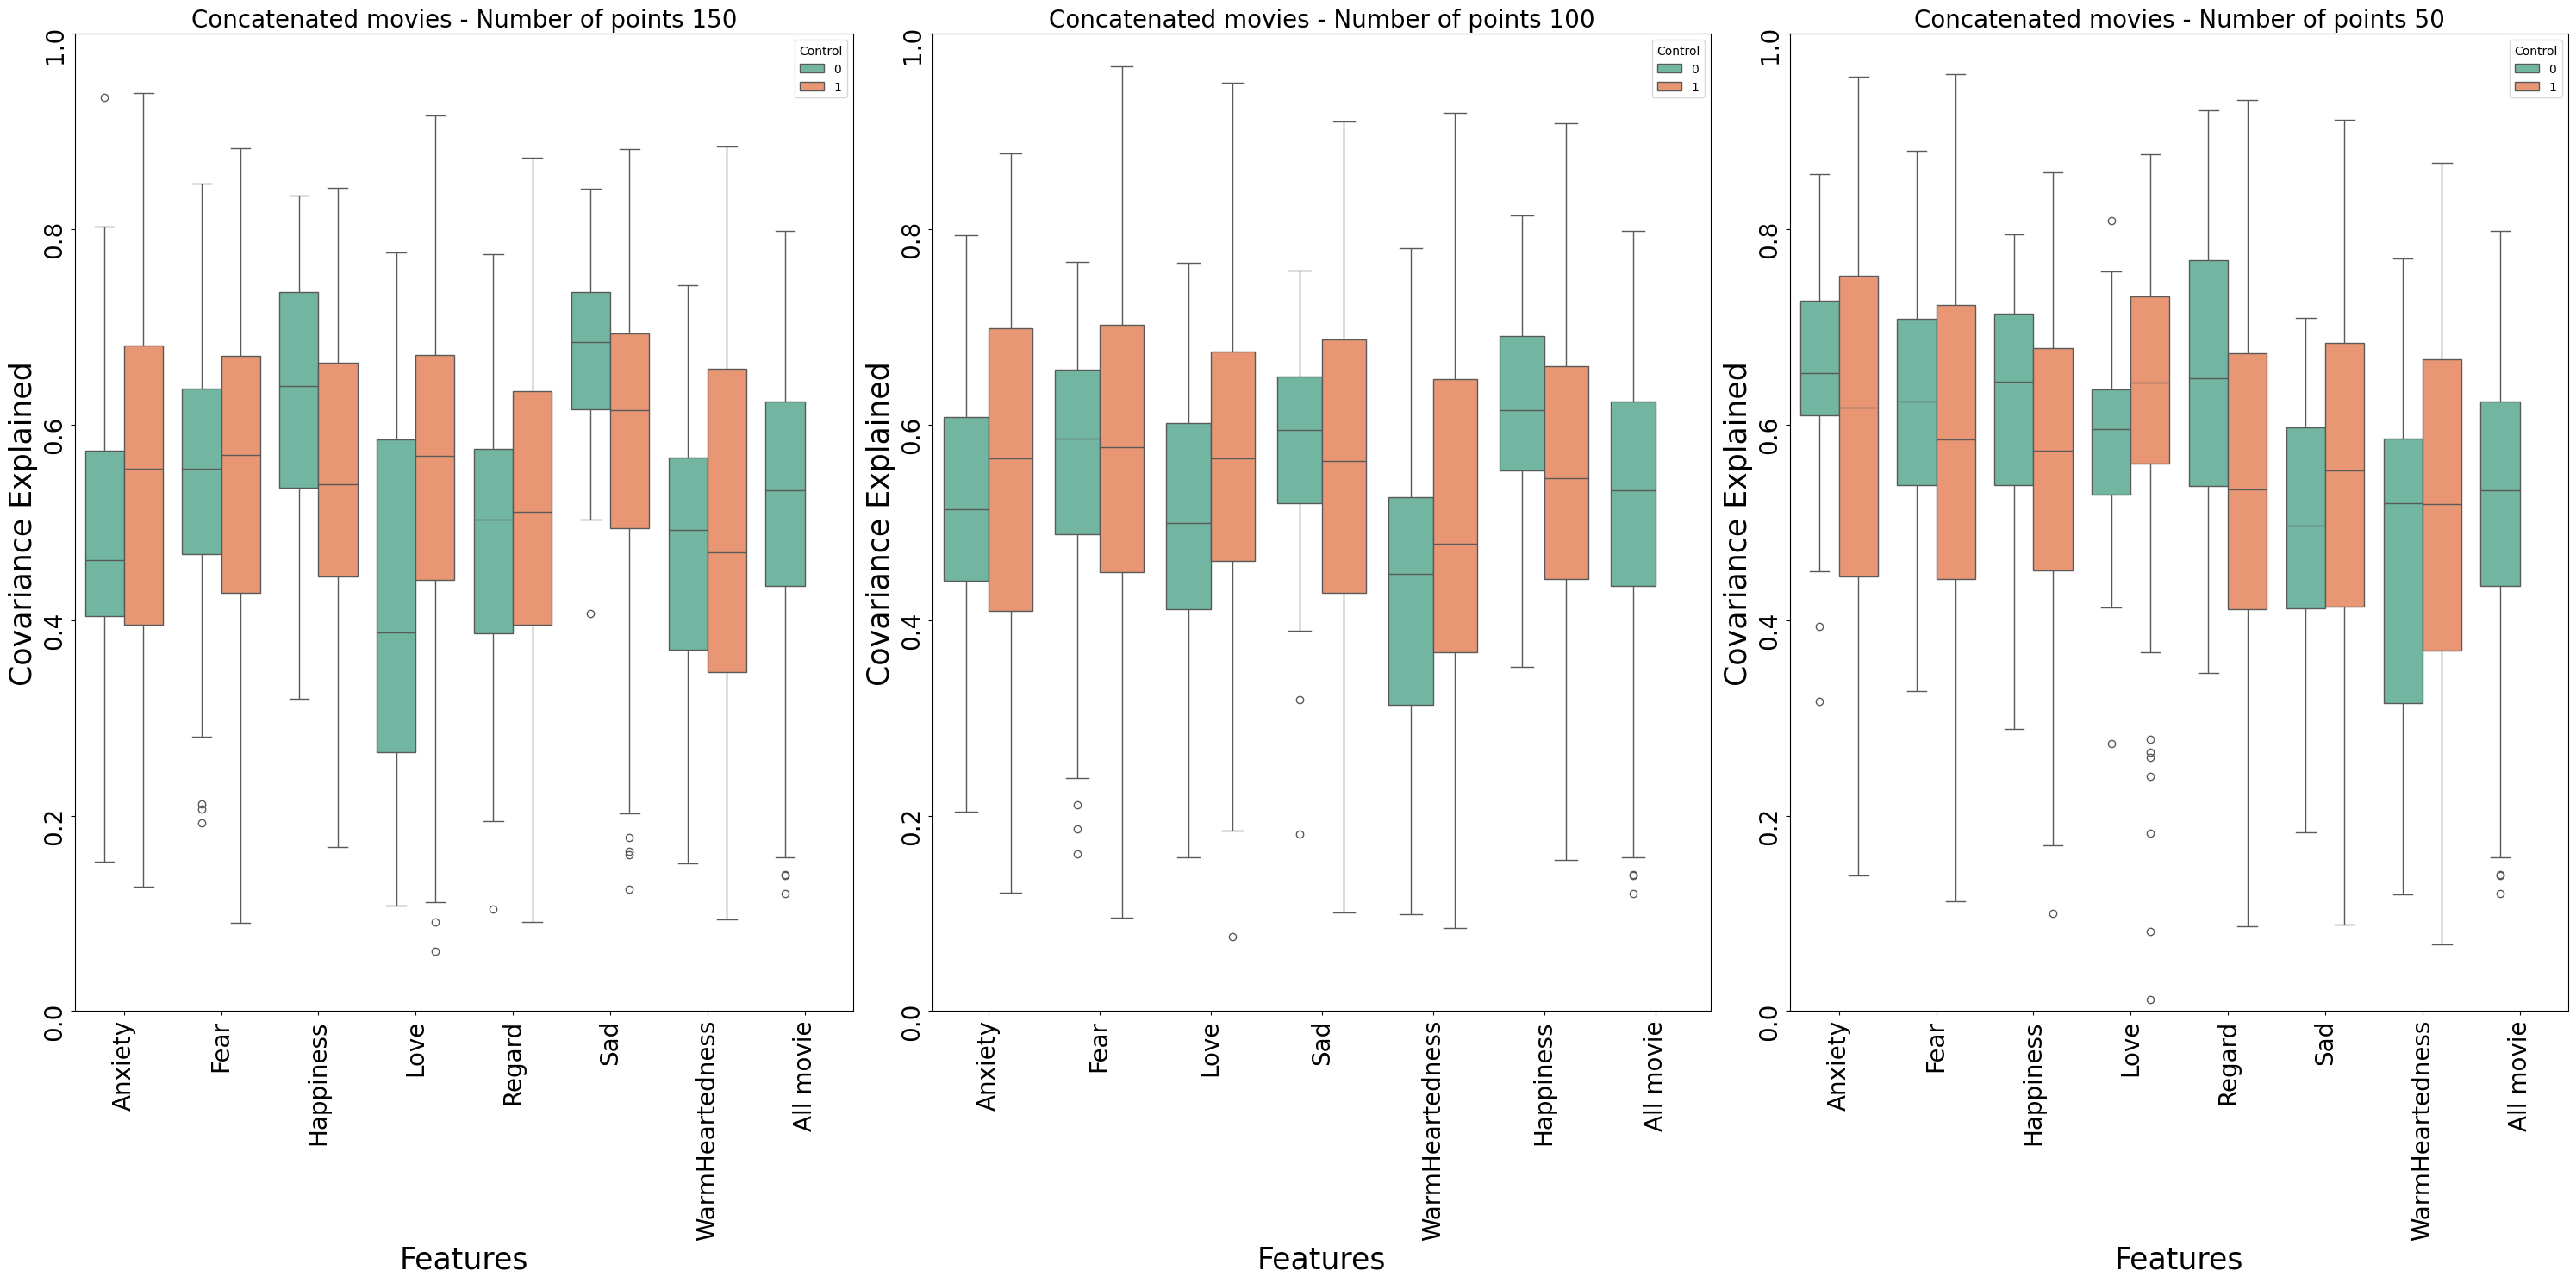

In [38]:
n_points = [50, 100, 150]

def retrieve_significant(peaks_data, data_all_movie):

    # Take the significant LC for the PLS on the peaks
    significant_peaks = peaks_data[peaks_data['P-value'] < 0.05]
    significant_peaks = significant_peaks.groupby(['Region', 'bootstrap_round', 'Feature', 'Number of points', 'threshold']).sum()['Covariance Explained'].reset_index()
    significant_peaks['Covariance Explained'] = significant_peaks['Covariance Explained'] / 2
    significant_peaks['Control'] = significant_peaks['Feature'].apply(lambda x: 1 if x.split('_')[0] == 'Control' else 0)
    significant_peaks['Feature'] = significant_peaks['Feature'].apply(lambda x: x.split('_')[-1])
    significant_peaks['Feature'] = significant_peaks['Feature'].apply(lambda x: 'average_' + x if x in ['brightness', 'saturation', 'hue'] else x)

    # Take the significant LC for the PLS on all the movie
    data_all_movie['Feature'] = 'All movie'
    significant_all_movie = data_all_movie[data_all_movie['P-value'] < 0.05]
    significant_all_movie = significant_all_movie.groupby(['Region', 'bootstrap_round', 'Feature']).sum()['Covariance Explained'].reset_index()
    significant_all_movie['Control'] = 0

    # Merge the dataframes
    significant = pd.concat([significant_peaks, significant_all_movie], ignore_index=True)

    significant.loc[significant['Feature'] == 'All movie', 'Number of points'] = 7000
    return significant

def plot_peaks_pts(significant, thresholds):
    palette = sns.color_palette("Set2", 8)
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 15))  # Adjust the size as needed
    for i, thr in enumerate(thresholds):
        significant.loc[significant['Feature'] == 'All movie', 'Number of points'] = thr
        df_thr = significant[significant['Number of points'] == thr]

        sns.boxplot(x='Feature', y='Covariance Explained', data=df_thr,  hue='Control', ax=axes[i], palette=palette)

        axes[i].set_title(f'Concatenated movies - Number of points {thr}', fontsize=20)
        axes[i].set_ylim(0, 1)
        axes[i].set_xlabel('Features', fontsize=25)
        axes[i].set_ylabel('Covariance Explained', fontsize=25)
        # font size of the x and y ticks 
        axes[i].tick_params(axis='both', which='major', labelsize=20, rotation=90)
        axes[i].tick_params(axis='both', which='minor', labelsize=20, rotation=90)

    plt.tight_layout()
    plt.show()

significant = retrieve_significant(peaks_data, data_all)
plot_peaks_pts(significant, [150, 100, 50])

/var/folders/kh/fr43342j0b998y80lvy2k2qh0000gn/T/ipykernel_78671/4038158765.py:6: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.boxplot(x='Feature', y='Covariance Explained', data=df,  hue='Number of points', palette=palette, hue_order=[150, 100, 50])


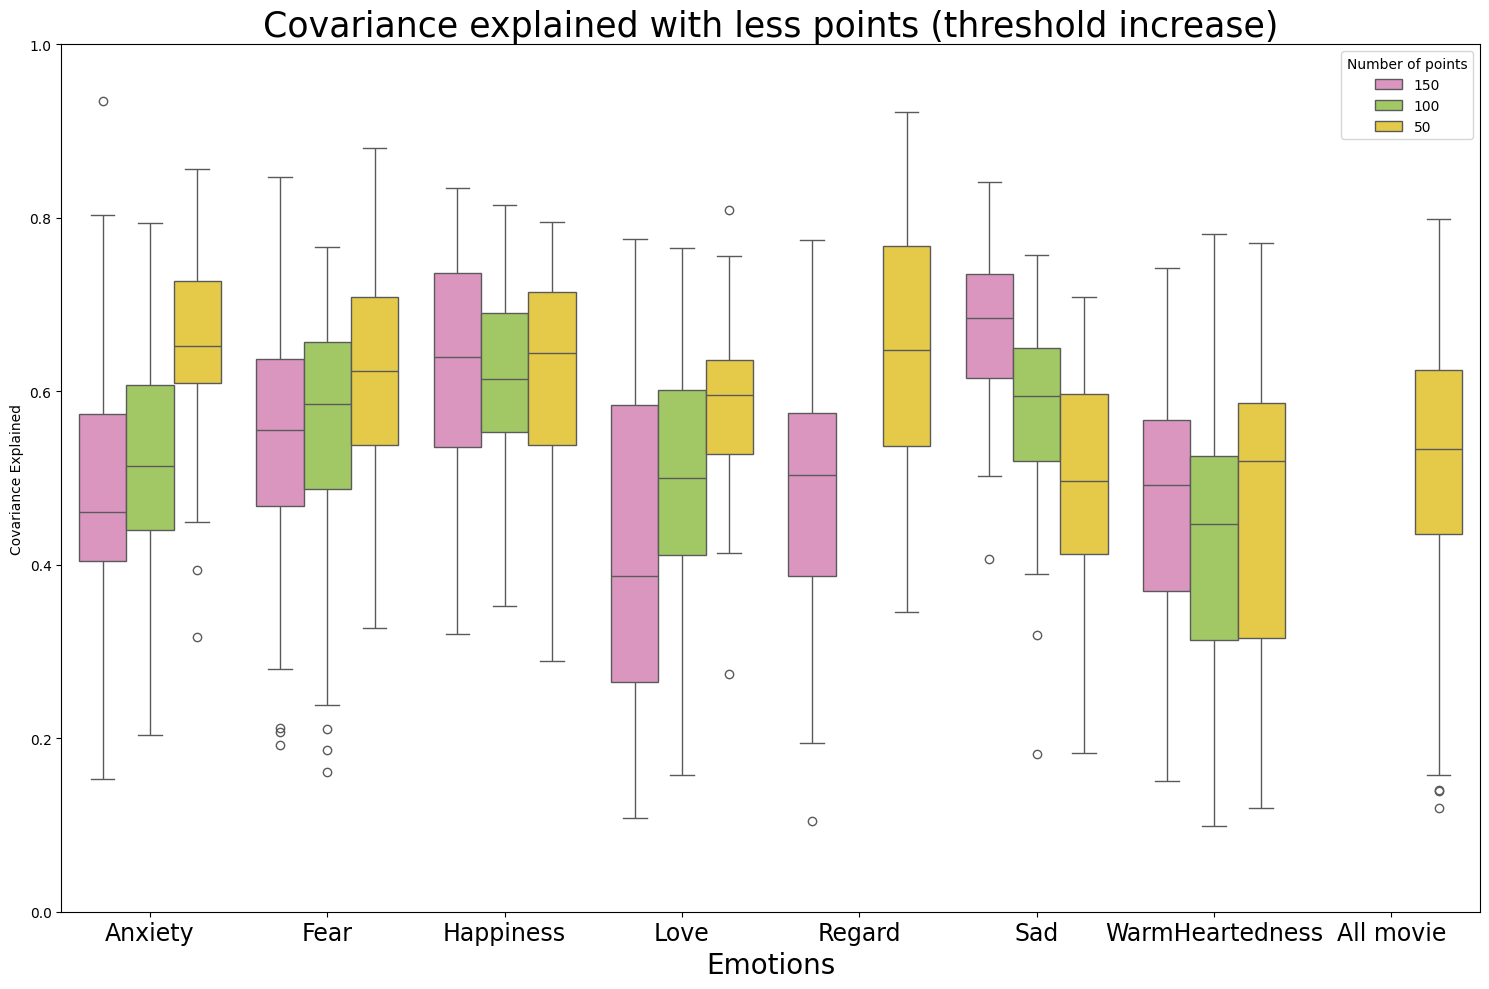

In [39]:
palette = sns.color_palette("Set2", 8)[3:8]

df = significant[significant['Control'] == 0]

plt.figure(figsize=(15, 10))
sns.boxplot(x='Feature', y='Covariance Explained', data=df,  hue='Number of points', palette=palette, hue_order=[150, 100, 50])

plt.xlabel('Emotions', fontsize=20)
plt.title(f'Covariance explained with less points (threshold increase)', fontsize=25)
plt.xticks(fontsize=17)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()